## Menentukan Pertanyaan Bisnis

Sebagai seorang Data Analyst di perusahaan E-Commerce ini, saya ingin menggali *insight* dari data historis untuk membantu tim bisnis dan pemasaran membuat keputusan yang lebih baik. Fokus analisis ini akan menjawab tiga pertanyaan strategis berikut:

1. **Produk Terlaris & Underperforming:** Produk kategori apa yang menyumbang pendapatan (revenue) terbesar dan terendah bagi perusahaan selama periode 2017-2018?
2. **Tren Pendapatan:** Bagaimana tren pendapatan perusahaan per bulan (monthly revenue) dan apakah terdapat pola musiman (seasonality) selama periode analisis?
3. **Analisis Pelanggan (RFM):** Bagaimana segmentasi pelanggan berdasarkan analisis RFM (Recency, Frequency, Monetary), dan segmen mana yang paling loyal?

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set(style='darkgrid')
plt.style.use('bmh')

## Data Wrangling

Tahap ini krusial. Kita akan mengumpulkan semua tabel data yang relevan, memeriksa kesehatannya (missing value, duplikasi), dan membersihkannya agar siap dianalisis.

In [52]:
#Gathering Data

# Load dataset utama yang diperlukan untuk analisis Order & Customer
# fokus kita adalah analisis performa penjualan dan pelanggan.

orders_df = pd.read_csv("data/orders_dataset.csv")
items_df = pd.read_csv("data/order_items_dataset.csv")
products_df = pd.read_csv("data/products_dataset.csv")
customers_df = pd.read_csv("data/customers_dataset.csv")
category_translation_df = pd.read_csv("data/product_category_name_translation.csv")

# Menampilkan sampel data 
print("Data Orders siap. Ukuran:", orders_df.shape)
orders_df.head(3)

Data Orders siap. Ukuran: (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [53]:
#Assessing Data

# Cek Info Data Orders 
print("--- Info Orders_DF ---")
orders_df.info()

# Cek Missing Values
print("\n--- Missing Values di Orders ---")
print(orders_df.isna().sum())

# Cek Duplikasi
print(f"\nJumlah duplikasi data order: {orders_df.duplicated().sum()}")

--- Info Orders_DF ---
<class 'pandas.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   order_id                       99441 non-null  str  
 1   customer_id                    99441 non-null  str  
 2   order_status                   99441 non-null  str  
 3   order_purchase_timestamp       99441 non-null  str  
 4   order_approved_at              99281 non-null  str  
 5   order_delivered_carrier_date   97658 non-null  str  
 6   order_delivered_customer_date  96476 non-null  str  
 7   order_estimated_delivery_date  99441 non-null  str  
dtypes: str(8)
memory usage: 6.1 MB

--- Missing Values di Orders ---
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
or

### Cleaning Data
Dari hasil assessment di atas, ditemukan beberapa isu yang perlu diperbaiki:
1.  Kolom-kolom tanggal (timestamp) masih bertipe `object` (string), harus diubah ke `datetime`.
2.  Nama kategori produk masih dalam Bahasa Portugis. Kita perlu menggabungkannya dengan tabel terjemahan agar mudah dibaca (Bahasa Inggris).
3.  Kita hanya akan memproses pesanan dengan status **'delivered'** karena itu merepresentasikan transaksi yang valid dan sukses secara bisnis.

In [54]:
# Memperbaiki Tipe Data 
datetime_cols = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]

for col in datetime_cols:
    orders_df[col] = pd.to_datetime(orders_df[col])

# Translate Kategori Produk 
# Merge products dengan translation
products_df = pd.merge(
    products_df,
    category_translation_df,
    on="product_category_name",
    how="left"
)

# Rename kolom agar lebih intuitif dan isi nilai yang hilang dengan "Others"
products_df.rename(columns={"product_category_name_english": "category"}, inplace=True)
products_df["category"].fillna("Others", inplace=True)

# Filter Valid Orders 
# hanya mengambil order yang sudah 'delivered'
orders_clean = orders_df[orders_df['order_status'] == 'delivered'].copy()

print("Data Cleaning Selesai.")
print(f"Sisa data valid: {orders_clean.shape[0]} transaksi.")

Data Cleaning Selesai.
Sisa data valid: 96478 transaksi.


C:\Users\yusti\AppData\Local\Temp\ipykernel_26980\1008630769.py:18: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  products_df["category"].fillna("Others", inplace=True)


## Exploratory Data Analysis (EDA)

Di tahap ini, kita akan menggabungkan beberapa tabel terpisah (Orders, Items, Customers, Products) menjadi satu kesatuan data utuh (*All Data*) untuk mempermudah visualisasi.

In [55]:
# Menggabungkan Orders dengan Items (untuk dapat harga)
all_df = pd.merge(
    left=orders_clean,
    right=items_df,
    how="left",
    left_on="order_id",
    right_on="order_id"
)

# Menggabungkan dengan Products (untuk dapat kategori)
all_df = pd.merge(
    left=all_df,
    right=products_df,
    how="left",
    left_on="product_id",
    right_on="product_id"
)

# Menggabungkan dengan Customers (untuk dapat ID unik pelanggan)
all_df = pd.merge(
    left=all_df,
    right=customers_df,
    how="left",
    left_on="customer_id",
    right_on="customer_id"
)

# Menghitung Total Sales per Order (Price + Freight)
all_df['total_value'] = all_df['price'] + all_df['freight_value']

all_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,...,400.0,19.0,13.0,19.0,perfumery,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,...,420.0,24.0,19.0,21.0,auto,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,...,450.0,30.0,10.0,20.0,pet_shop,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,...,250.0,51.0,15.0,15.0,stationery,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,28.62


In [56]:
# Melihat rangkuman statistik deskriptif (termasuk non-numerik)
print(all_df.describe(include="all"))


                                order_id                       customer_id  \
count                             110197                            110197   
unique                             96478                             96478   
top     8272b63d03f5f79c56e9e4120aec44ef  fc3d1daec319d62d49bfb5e1f83123e9   
freq                                  21                                21   
mean                                 NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   
std                                  NaN                               NaN   

       order_status    order_purchase_timestamp           order

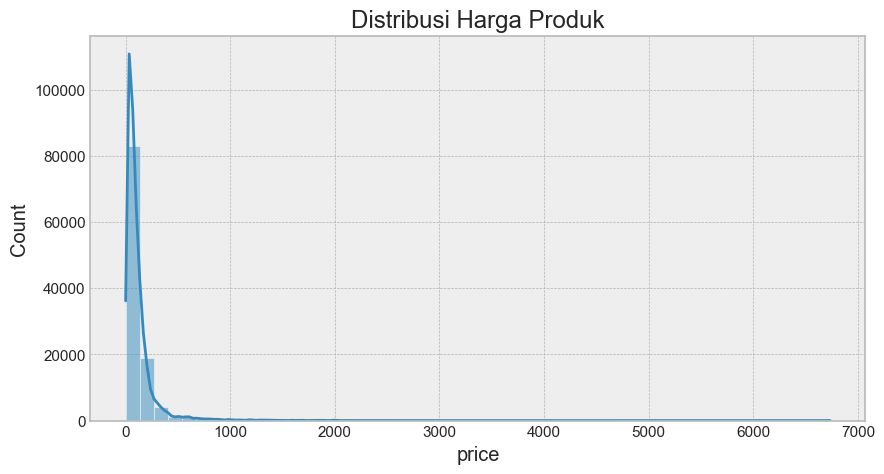

In [57]:

# Melihat distribusi harga (Price)
plt.figure(figsize=(10, 5))
sns.histplot(all_df['price'], bins=50, kde=True)
plt.title("Distribusi Harga Produk")
plt.show()


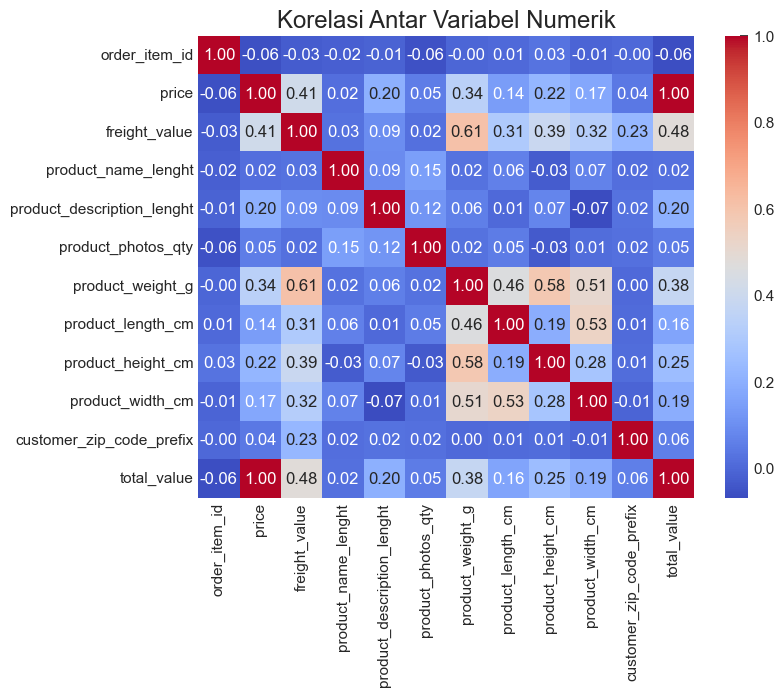

In [58]:

# Melihat korelasi antar variabel numerik 
numeric_cols = all_df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Variabel Numerik")
plt.show()

## Visualization & Explanatory Analysis

Mari  menjawab pertanyaan bisnis yang sudah ditetapkan di awal dengan visualisasi data.

### 1. Produk Apa yang Paling Laris dan Paling Tidak Laris?
Visualisasi ini akan membantu tim Inventory dan Marketing. Produk laris perlu dijaga stoknya, sedangkan produk tidak laris mungkin perlu promo *bundle* atau diskon cuci gudang.

C:\Users\yusti\AppData\Local\Temp\ipykernel_26980\792204156.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="quantity", y="category", data=top_products, palette=colors_top, ax=ax[0])
C:\Users\yusti\AppData\Local\Temp\ipykernel_26980\792204156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="quantity", y="category", data=worst_products, palette=colors_worst, ax=ax[1])


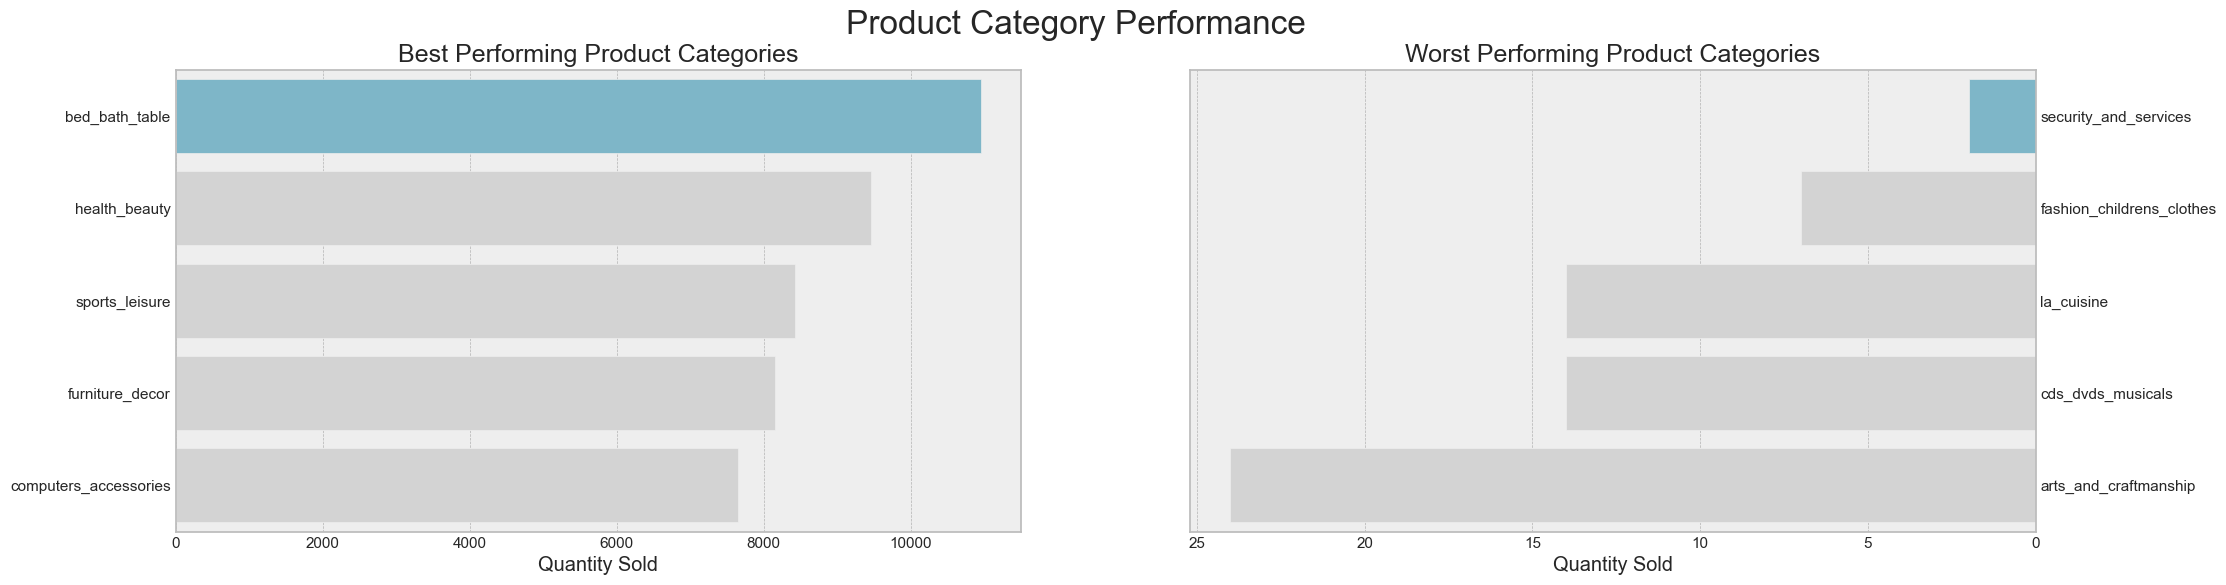

In [59]:
# Agregasi data berdasarkan kategori produk
product_performance = all_df.groupby("category").agg({
    "product_id": "count"
}).reset_index().rename(columns={"product_id": "quantity"})

top_products = product_performance.sort_values(by="quantity", ascending=False).head(5)
worst_products = product_performance.sort_values(by="quantity", ascending=True).head(5)

# Visualisasi
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
colors_top = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
colors_worst = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"] 

sns.barplot(x="quantity", y="category", data=top_products, palette=colors_top, ax=ax[0])
ax[0].set_title("Best Performing Product Categories", fontsize=18)
ax[0].set_xlabel("Quantity Sold")
ax[0].set_ylabel(None)

sns.barplot(x="quantity", y="category", data=worst_products, palette=colors_worst, ax=ax[1])
ax[1].set_title("Worst Performing Product Categories", fontsize=18)
ax[1].set_xlabel("Quantity Sold")
ax[1].set_ylabel(None)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

plt.suptitle("Product Category Performance", fontsize=24)
plt.show()

### 2. Bagaimana Performa Penjualan dari Waktu ke Waktu?
Kita akan melihat tren bulanan untuk mengidentifikasi pola musiman. Penting untuk persiapan *campaign* tahunan.

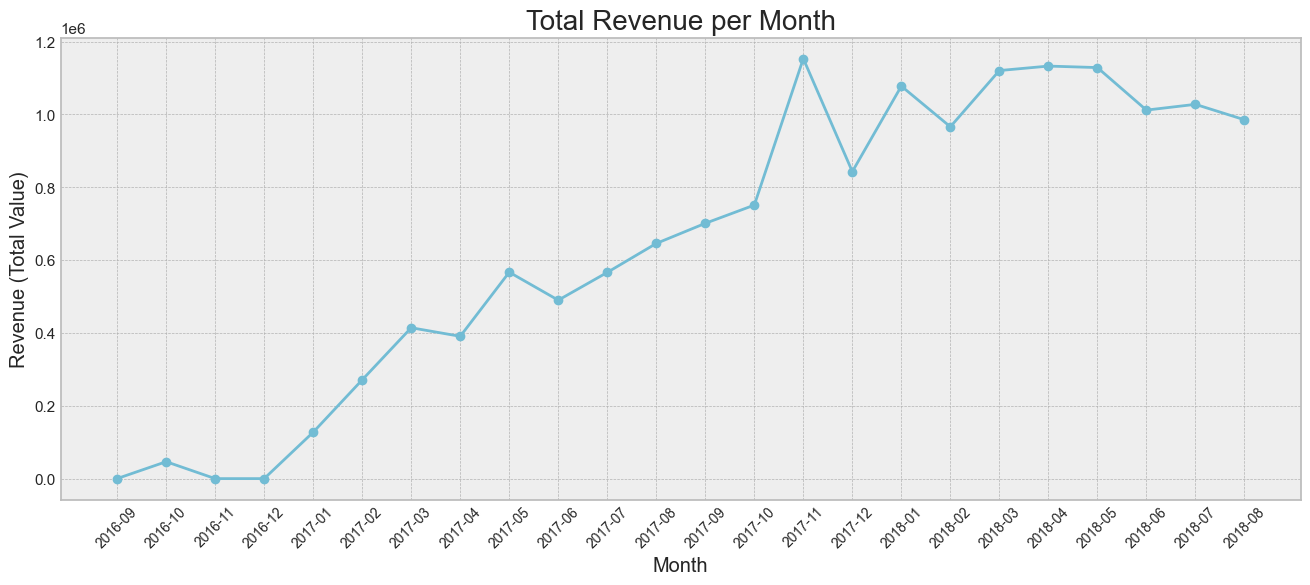

In [60]:
# Resample data ke bulanan (Monthly)
monthly_orders = all_df.resample(rule='ME', on='order_purchase_timestamp').agg({
    "order_id": "nunique",
    "total_value": "sum"
})
monthly_orders.index = monthly_orders.index.strftime('%Y-%m') 
monthly_orders = monthly_orders.reset_index()

# Plotting Line Chart
plt.figure(figsize=(16, 6))
plt.plot(
    monthly_orders["order_purchase_timestamp"],
    monthly_orders["total_value"],
    marker='o',
    linewidth=2,
    color="#72BCD4"
)
plt.title("Total Revenue per Month", fontsize=20)
plt.xticks(fontsize=10, rotation=45)
plt.ylabel("Revenue (Total Value)")
plt.xlabel("Month")
plt.grid(True)
plt.show()

### 3. Analisis Pelanggan Terbaik (RFM Analysis)
Saya akan menanalisis teknik lebih lanjut, kita akan mengetahui 3 metrik dibawah berdasarkan data yang kita olah:
* **Recency**: Kapan terakhir kali transaksi? (Semakin baru, semakin baik).
* **Frequency**: Seberapa sering bertransaksi?
* **Monetary**: Berapa banyak uang yang mereka habiskan?

In [61]:
# Grouping data berdasarkan customer_unique_id 
rfm_df = all_df.groupby(by="customer_unique_id", as_index=False).agg({
    "order_purchase_timestamp": "max", # Mengambil tanggal order terakhir
    "order_id": "nunique",             # Menghitung jumlah order unik
    "total_value": "sum"               # Menghitung total belanja
})

rfm_df.columns = ["customer_id", "max_order_timestamp", "frequency", "monetary"]

# Hitung Recency (Jarak hari dari tanggal terakhir dataset ke tanggal pembelian user)
recent_date = orders_clean["order_purchase_timestamp"].max()
rfm_df["recency"] = rfm_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)

rfm_df.drop("max_order_timestamp", axis=1, inplace=True)

# Tampilkan sampel hasil RFM
rfm_df.head()

,customer_id,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,114
2,0000f46a3911fa3c0805444483337064,1,86.22,536
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,320
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,287


C:\Users\yusti\AppData\Local\Temp\ipykernel_26980\1422975801.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
C:\Users\yusti\AppData\Local\Temp\ipykernel_26980\1422975801.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
C:\Users\yusti\AppData\Local\Temp\ipykernel_26980\1422975801.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

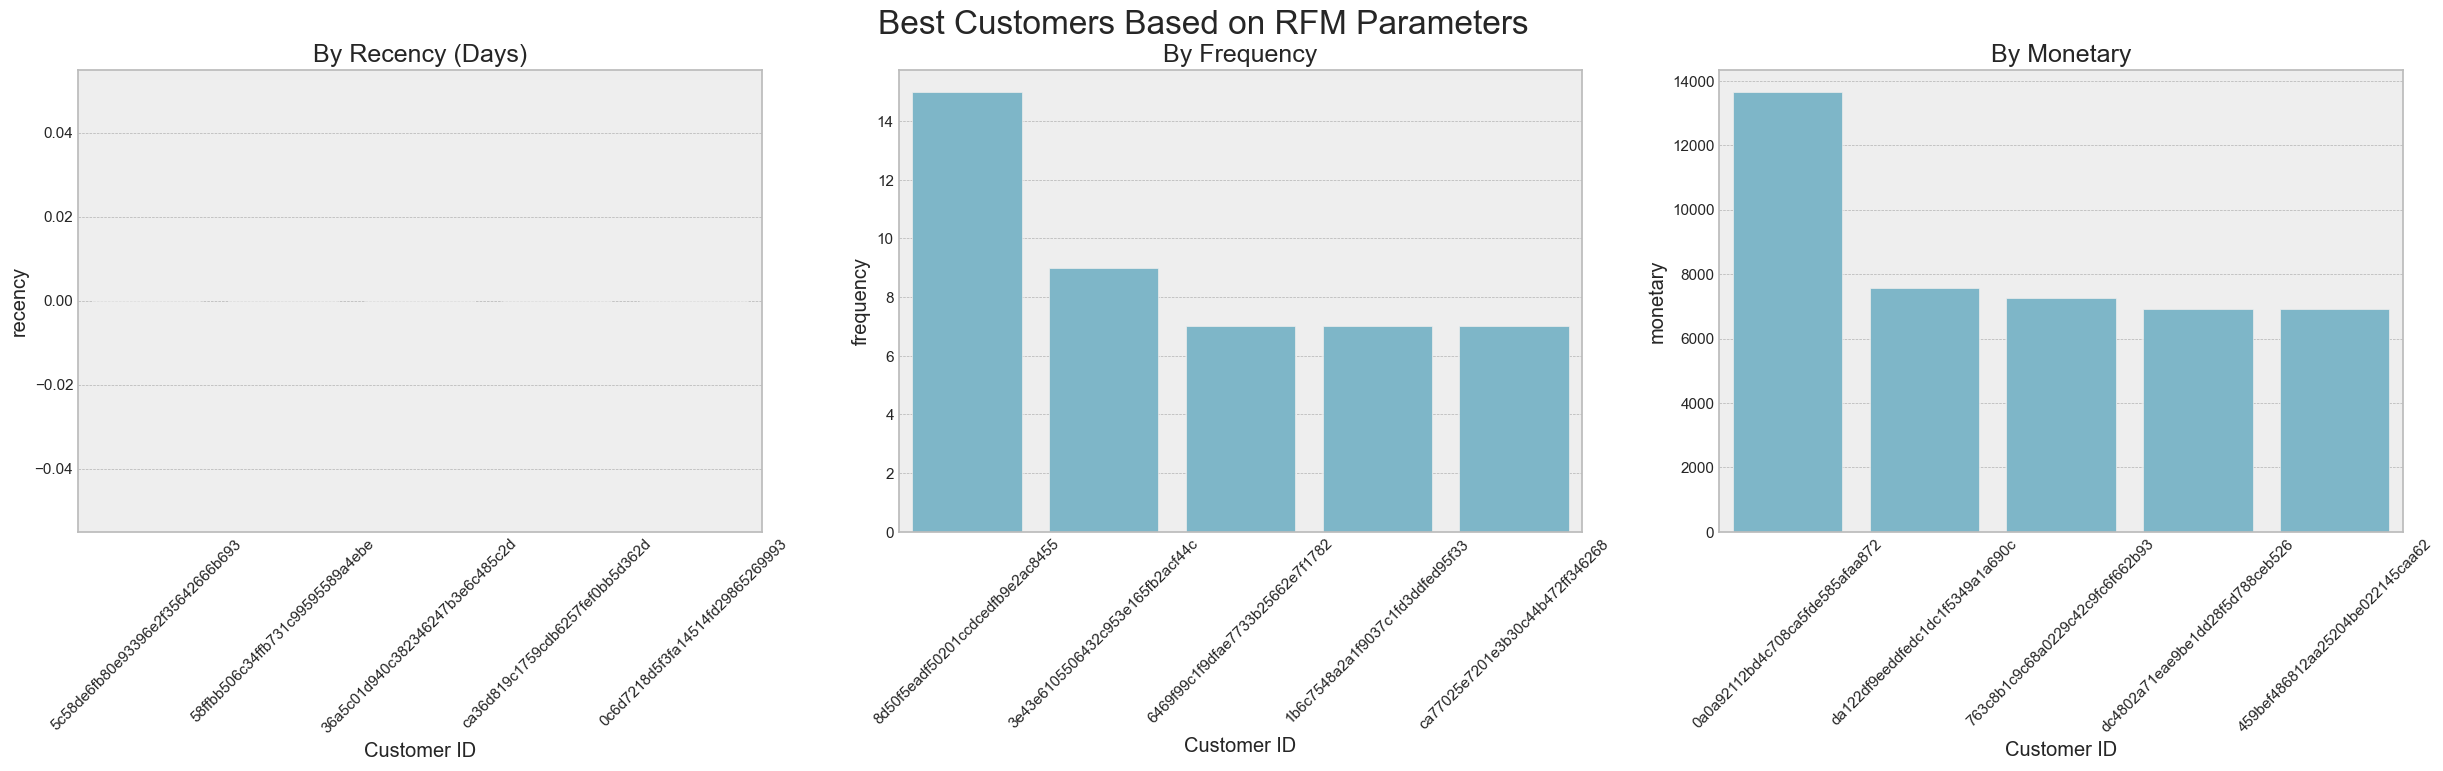

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
colors = ["#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]

# Plot Recency (Nilai lebih kecil lebih baik)
sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
ax[0].set_title("By Recency (Days)", fontsize=18)
ax[0].set_xlabel("Customer ID")
ax[0].tick_params(axis='x', rotation=45)

# Plot Frequency
sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
ax[1].set_title("By Frequency", fontsize=18)
ax[1].set_xlabel("Customer ID")
ax[1].tick_params(axis='x', rotation=45)

# Plot Monetary
sns.barplot(y="monetary", x="customer_id", data=rfm_df.sort_values(by="monetary", ascending=False).head(5), palette=colors, ax=ax[2])
ax[2].set_title("By Monetary", fontsize=18)
ax[2].set_xlabel("Customer ID")
ax[2].tick_params(axis='x', rotation=45)

plt.suptitle("Best Customers Based on RFM Parameters", fontsize=24)
plt.show()

## Conclusion & Recommendation

### Conclusion

Berdasarkan analisis data menyeluruh yang telah dilakukan, berikut adalah kesimpulan strategis untuk menjawab pertanyaan bisnis:

1.  **Analisis Produk (Product Performance):**
    -   **Top Performing:** Kategori **Bed Bath Table** (dan *Health Beauty*) secara konsisten menjadi penyumbang pendapatan (*Revenue*) terbesar bagi perusahaan. Tingginya volume transaksi pada kategori ini mengindikasikan bahwa ini adalah produk kebutuhan utama pelanggan.
    -   **Underperforming:** Kategori **Security and Services** menunjukkan kinerja penjualan yang sangat rendah. Hal ini bisa disebabkan oleh kurangnya variasi produk, harga yang tidak kompetitif, atau kurangnya minat pasar pada platform ini untuk kategori tersebut.

2.  **Tren Pendapatan & Musiman (Revenue Trend):**
    -   **Pertumbuhan Positif:** Secara garis besar, perusahaan mengalami tren kenaikan pendapatan yang signifikan dari awal tahun 2017 hingga pertengahan 2018.
    -   **Pola Musiman (Seasonality):** Terdapat lonjakan pendapatan yang sangat tajam pada bulan **November 2017**. Hal ini mengonfirmasi adanya pola musiman tahunan, yang kemungkinan besar didorong oleh event **Black Friday( acara diskon besar-besaran sedunia)**. Setelah periode puncak tersebut, penjualan cenderung stabil namun tidak setinggi bulan November.

3.  **Segmentasi Pelanggan (RFM Analysis):**
    -   **Recency (Kebaruan):** Mayoritas pelanggan melakukan transaksi terakhir mereka cukup lama (beberapa bulan lalu), yang mengindikasikan perlunya strategi *re-engagement*.
    -   **Frequency (Frekuensi):** Sebagian besar pelanggan hanya melakukan transaksi **satu kali** (*one-time buyer*). Tingkat retensi pelanggan (*customer retention rate*) masih tergolong rendah.
    -   **Monetary (Nilai Uang):** Terdapat segelintir pelanggan "VIP" yang memberikan kontribusi pendapatan sangat besar dibandingkan rata-rata pelanggan lain. Kelompok kecil ini sangat krusial bagi cash flow perusahaan.

---

### Recommendation (Actionable Insights)

Berdasarkan temuan di atas, berikut adalah rekomendasi aksi bisnis yang disarankan:

1.  **Strategi Manajemen Produk:**
    -   **Jaga Stok Best Seller:** Pastikan ketersediaan stok (*Safety Stock*) untuk kategori *Bed Bath Table* dan *Health Beauty* selalu aman, terutama di Q4 (Kuartal 4), untuk mencegah *stock-out* yang merugikan.
    -   **Evaluasi Produk Lemah:** Pertimbangkan strategi *bundling* (paket hemat) untuk produk *Security and Services*. Jika tidak ada perbaikan performa dalam 3 bulan, pertimbangkan untuk menghapus kategori ini demi efisiensi biaya operasional.

2.  **Optimasi Pemasaran Berbasis Waktu:**
    -   **Fokus Q4 (Black Friday):** Mengingat November adalah bulan dengan *Revenue* tertinggi, tim pemasaran harus memulai kampanye besar (Teaser Ads, Pre-order) sejak bulan **Oktober**. Alokasikan 40-50% budget marketing tahunan di periode ini.
    -   **Kampanye Low-Season:** Untuk bulan-bulan setelah peak season (Januari-Februari), buat promo "New Year Sale" atau "Cuci Gudang" untuk menjaga grafik pendapatan tetap stabil.

3.  **Customer Retention & Loyalty Program:**
    -   **Ubah One-Time Buyer jadi Loyal:** Karena Frequency mayoritas adalah 1, kirimkan *Email Marketing* yang dipersonalisasi berisi "Voucher Diskon Pembelian Kedua" atau rekomendasi produk pelengkap (misal: Beli sprei, direkomendasikan beli bantal).
    -   **Program VIP Eksklusif:** Untuk pelanggan dengan nilai Monetary tinggi (High Spenders), berikan status "Priority" dengan keuntungan seperti pengiriman gratis instan atau akses awal ke produk baru. Hal ini akan meningkatkan ikatan emosional dan mencegah mereka pindah ke kompetitor.

In [63]:
# Simpan dataset yang sudah bersih ke folder dashboard
all_df.to_csv("dashboard/main_data.csv", index=False)